# 🏢 Global Data Center Analysis
**Goal:** Understand the global data center landscape — capacity, renewable energy adoption, growth trends, and energy efficiency — across 191 countries.

**Key Questions:**
1. Which countries lead in data center count and power capacity?
2. How does renewable energy adoption vary across regions?
3. What predicts higher renewable energy usage?
4. How are internet penetration and latency related to data center density?
5. Can we cluster countries into meaningful data center maturity profiles?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
import re

pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:.2f}'.format)

PALETTE = px.colors.qualitative.Plotly
print('Libraries loaded ✓')

Libraries loaded ✓


## 1. Load & Clean Data

In [2]:
df_raw = pd.read_csv('Data/DataCenterDataset.csv')

# Drop junk trailing columns
df = df_raw.drop(columns=[c for c in df_raw.columns if c.startswith('Unnamed')]).copy()

print(f'Shape: {df.shape}')
df.head(3)

Shape: (191, 19)


,country,total_data_centers,hyperscale_data_centers,colocation_data_centers,floor_space_sqft_total,power_capacity_MW_total,average_renewable_energy_usage_percent,tier_distribution,key_operators,cloud_provider,internet_penetration_percent,avg_latency_to_global_hubs_ms,number_of_fiber_connections,growth_rate_of_data_centers_percent_per_year,cooling_technologies_common,regulatory_challenges_or_limits,disaster_recovery_sites_common,green_dc_initiatives_description,source_of_data
0,United States,5426,300+,"~2,000+","~3,552,000,000","~12,000+",~27%,"I:5%, II:15%, III:60%, IV:20%","Equinix, Digital Realty, CoreSite, AWS","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",92%,40,60+,12%,"Air, Liquid, Immersion","Power grid strain in VA, moratoriums in some s...","Yes, especially for finance/health","Solar, wind PPA, immersion cooling, LEED","Statista, Brightlio, IEA, CBRE"
1,Germany,529,50,~200,"~350,000,000","~2,000+",40%+,"II:10%, III:70%, IV:20%","Equinix, Digital Realty, e-shelter","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",92%,50,30+,8%,"Air, Indirect Evap.","Power caps in Frankfurt, strict emissions","Yes, especially for finance","Wind, solar, carbon-neutral push","Statista, CBRE, IEA"
2,United Kingdom,523,30,~150,"~200,000,000","~1,000+",0.45,"II:15%, III:70%, IV:15%","Equinix, Telehouse, Virtus","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",96%,40,25+,7%,"Air, Free Cooling",Power grid constraints in London,"Yes, especially for finance","Wind, solar, carbon-neutral targets","Statista, CBRE, IEA"


In [3]:
def parse_numeric(val, scale=1.0):
    """Extract the first number from messy strings like '~12,000+', '40%+', 'Unknown'."""
    if pd.isna(val) or str(val).strip().lower() in ('unknown', 'n/a', '-', ''):
        return np.nan
    s = re.sub(r'[~+,\s]', '', str(val))
    s = s.replace('%', '')
    # Take first number found
    m = re.search(r'\d+\.?\d*', s)
    if m:
        num = float(m.group())
        # Handle decimal percentages stored as 0.xx instead of xx
        if scale == 'pct' and num < 1.5:
            num *= 100
        return num * (1.0 if scale == 'pct' else scale)
    return np.nan


def parse_count(val):
    """Parse counts like '300+', '~2,000+' → float."""
    return parse_numeric(val)


df['hyperscale_n']   = df['hyperscale_data_centers'].apply(parse_count)
df['colocation_n']   = df['colocation_data_centers'].apply(parse_count)
df['floor_space_m']  = df['floor_space_sqft_total'].apply(lambda x: parse_numeric(x)) / 1e6   # millions sqft
df['power_mw']       = df['power_capacity_MW_total'].apply(parse_numeric)
df['renewable_pct']  = df['average_renewable_energy_usage_percent'].apply(lambda x: parse_numeric(x, scale='pct'))
df['internet_pct']   = df['internet_penetration_percent'].apply(lambda x: parse_numeric(x, scale='pct'))
df['latency_ms']     = df['avg_latency_to_global_hubs_ms'].apply(parse_numeric)
df['fiber_n']        = df['number_of_fiber_connections'].apply(parse_count)
df['growth_pct']     = df['growth_rate_of_data_centers_percent_per_year'].apply(parse_numeric)
df['dc_count']       = df['total_data_centers']   # already int

# Clamp implausible renewable values (> 100 → divide by 100)
df.loc[df['renewable_pct'] > 100, 'renewable_pct'] /= 100
df.loc[df['internet_pct']  > 100, 'internet_pct']  /= 100

numeric_cols = ['dc_count','hyperscale_n','colocation_n','floor_space_m',
                'power_mw','renewable_pct','internet_pct','latency_ms','fiber_n','growth_pct']

print('Cleaned numeric columns:')
df[numeric_cols].describe().T[['count','mean','min','max']]

Cleaned numeric columns:


,count,mean,min,max
dc_count,191.00,60.69,0.00,5426.00
hyperscale_n,191.00,3.58,0.00,300.00
colocation_n,191.00,30.45,0.00,2000.00
floor_space_m,184.00,28.06,0.00,3552.00
power_mw,165.00,275.30,0.00,12000.00
renewable_pct,148.00,50.77,0.00,100.00
internet_pct,190.00,67.09,1.30,100.00
latency_ms,145.00,100.49,0.00,600.00
fiber_n,178.00,6.99,0.00,186.90
growth_pct,174.00,476.31,0.00,4900.00


## 2. Exploratory Data Analysis

In [4]:
# ── Top 20 countries by DC count ─────────────────────────────────────────────
top20 = df.nlargest(20, 'dc_count')[['country','dc_count','power_mw','renewable_pct']]

fig = px.bar(
    top20, x='dc_count', y='country', orientation='h',
    color='renewable_pct', color_continuous_scale='RdYlGn',
    range_color=[0, 100],
    labels={'dc_count': 'Total Data Centers', 'country': '',
            'renewable_pct': 'Renewable %'},
    title='Top 20 Countries by Data Center Count<br><sup>Color = Renewable energy %</sup>',
    height=600,
)
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

In [5]:
# ── World choropleth — Power capacity (MW) ───────────────────────────────────
fig = px.choropleth(
    df.dropna(subset=['power_mw']),
    locations='country', locationmode='country names',
    color='power_mw', color_continuous_scale='Blues',
    range_color=[0, df['power_mw'].quantile(0.95)],
    labels={'power_mw': 'Power Capacity (MW)'},
    title='Global Data Center Power Capacity (MW)',
    height=500,
)
fig.update_layout(coloraxis_colorbar_title='MW')
fig.show()

# ── Choropleth — Renewable energy % ──────────────────────────────────────────
fig2 = px.choropleth(
    df.dropna(subset=['renewable_pct']),
    locations='country', locationmode='country names',
    color='renewable_pct', color_continuous_scale='RdYlGn',
    range_color=[0, 100],
    labels={'renewable_pct': 'Renewable Energy %'},
    title='Renewable Energy Usage in Data Centers (%)',
    height=500,
)
fig2.show()

In [6]:
# ── Power capacity vs. Renewable % (bubble = DC count) ───────────────────────
plot_df = df.dropna(subset=['power_mw','renewable_pct','dc_count']).copy()
plot_df['log_power'] = np.log1p(plot_df['power_mw'])

fig = px.scatter(
    plot_df, x='renewable_pct', y='power_mw',
    size='dc_count', size_max=60,
    color='internet_pct', color_continuous_scale='Viridis',
    hover_name='country',
    log_y=True,
    labels={'renewable_pct': 'Renewable Energy (%)',
            'power_mw': 'Power Capacity (MW, log scale)',
            'internet_pct': 'Internet Penetration %'},
    title='Power Capacity vs. Renewable Energy<br><sup>Bubble size = # data centers | Color = Internet penetration</sup>',
    height=550,
)
# Label top 10
top10 = plot_df.nlargest(10, 'dc_count')
for _, row in top10.iterrows():
    fig.add_annotation(x=row['renewable_pct'], y=row['power_mw'],
                       text=row['country'], showarrow=False,
                       font=dict(size=9), yshift=10)
fig.show()

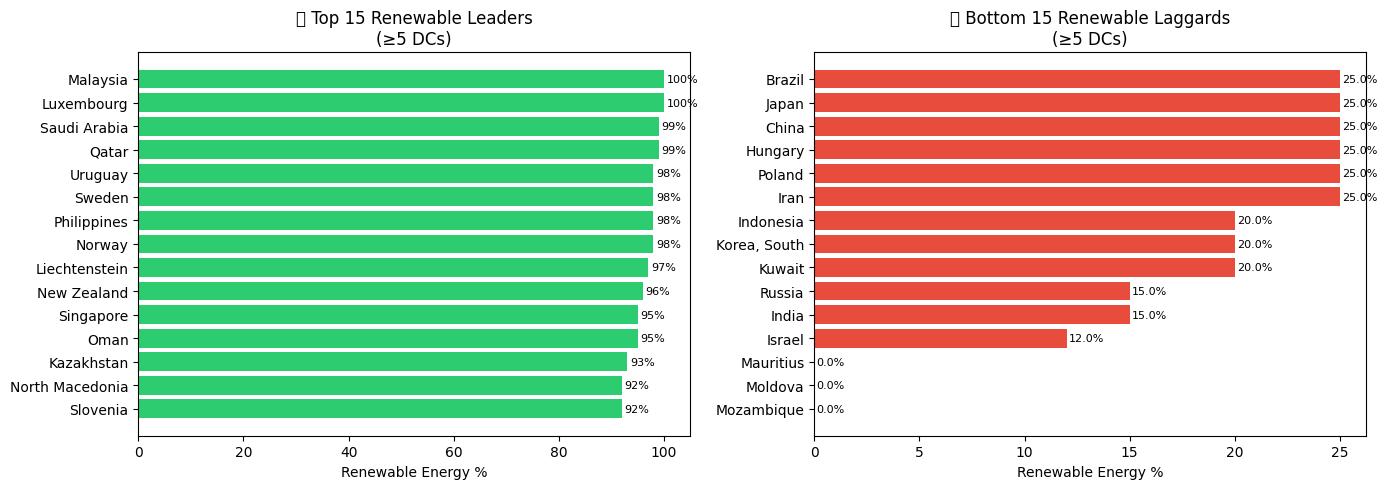

Global average renewable: 58.8%
Median renewable:         60.0%


In [7]:
# ── Renewable energy leaders vs. laggards ────────────────────────────────────
ren = df[['country','renewable_pct','dc_count']].dropna(subset=['renewable_pct'])
ren = ren[ren['dc_count'] >= 5].sort_values('renewable_pct', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Leaders
leaders = ren.head(15)
axes[0].barh(leaders['country'], leaders['renewable_pct'], color='#2ecc71')
axes[0].set_xlabel('Renewable Energy %')
axes[0].set_title('🟢 Top 15 Renewable Leaders\n(≥5 DCs)')
axes[0].invert_yaxis()
for i, v in enumerate(leaders['renewable_pct']):
    axes[0].text(v + 0.5, i, f'{v:.0f}%', va='center', fontsize=8)

# Laggards
laggards = ren.tail(15)
axes[1].barh(laggards['country'], laggards['renewable_pct'], color='#e74c3c')
axes[1].set_xlabel('Renewable Energy %')
axes[1].set_title('🔴 Bottom 15 Renewable Laggards\n(≥5 DCs)')
axes[1].invert_yaxis()
for i, v in enumerate(laggards['renewable_pct']):
    axes[1].text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f'Global average renewable: {ren["renewable_pct"].mean():.1f}%')
print(f'Median renewable:         {ren["renewable_pct"].median():.1f}%')

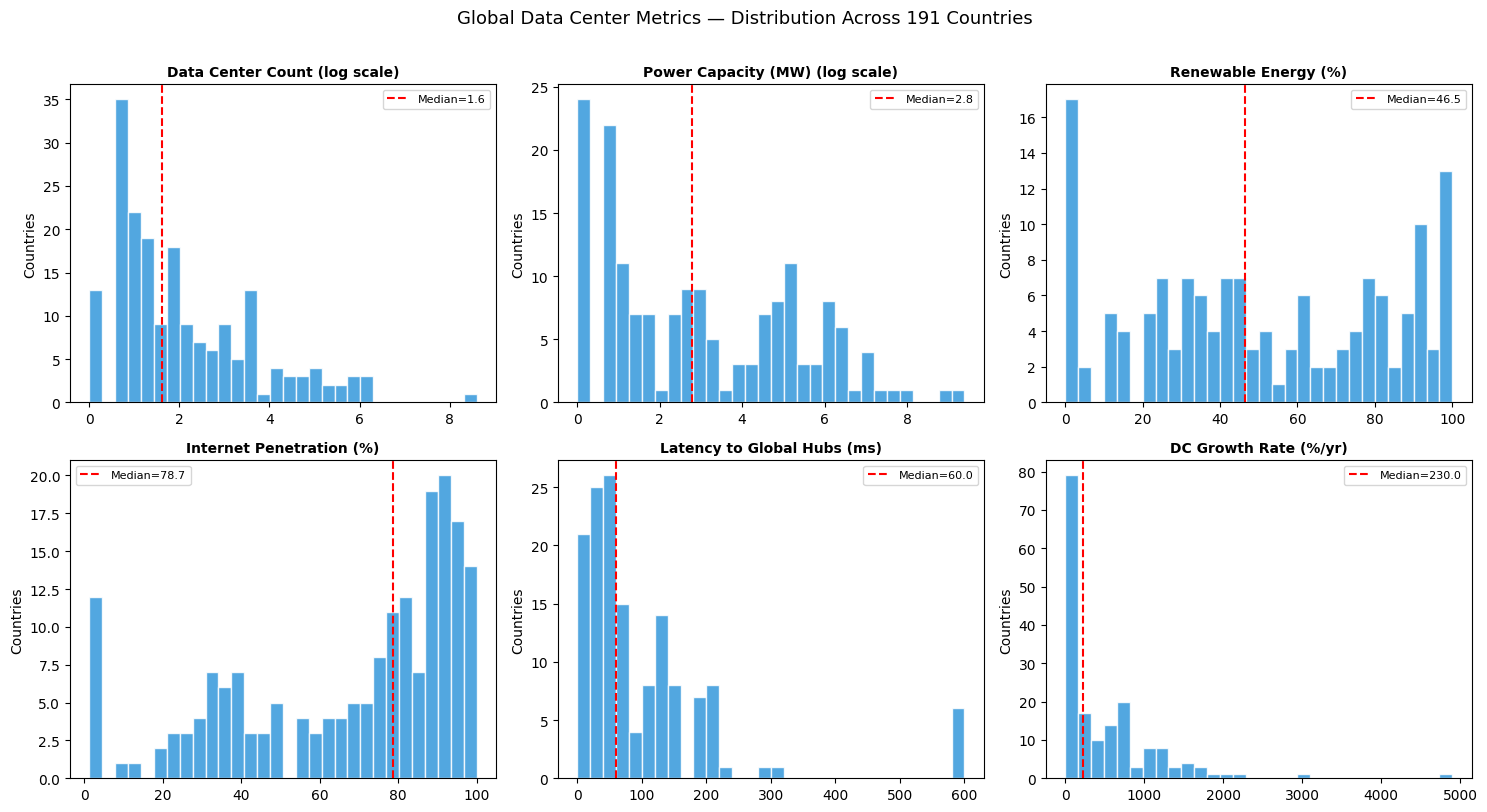

In [8]:
# ── Distribution grid ────────────────────────────────────────────────────────
plot_cols = {
    'dc_count':      'Data Center Count',
    'power_mw':      'Power Capacity (MW)',
    'renewable_pct': 'Renewable Energy (%)',
    'internet_pct':  'Internet Penetration (%)',
    'latency_ms':    'Latency to Global Hubs (ms)',
    'growth_pct':    'DC Growth Rate (%/yr)',
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (col, label) in zip(axes, plot_cols.items()):
    data_c = df[col].dropna()
    if col in ('dc_count', 'power_mw'):
        data_c = np.log1p(data_c)
        label  = f'{label} (log scale)'
    ax.hist(data_c, bins=30, color='#3498db', edgecolor='white', alpha=0.85)
    ax.axvline(data_c.median(), color='red', linestyle='--', linewidth=1.5, label=f'Median={data_c.median():.1f}')
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_ylabel('Countries')
    ax.legend(fontsize=8)

plt.suptitle('Global Data Center Metrics — Distribution Across 191 Countries', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

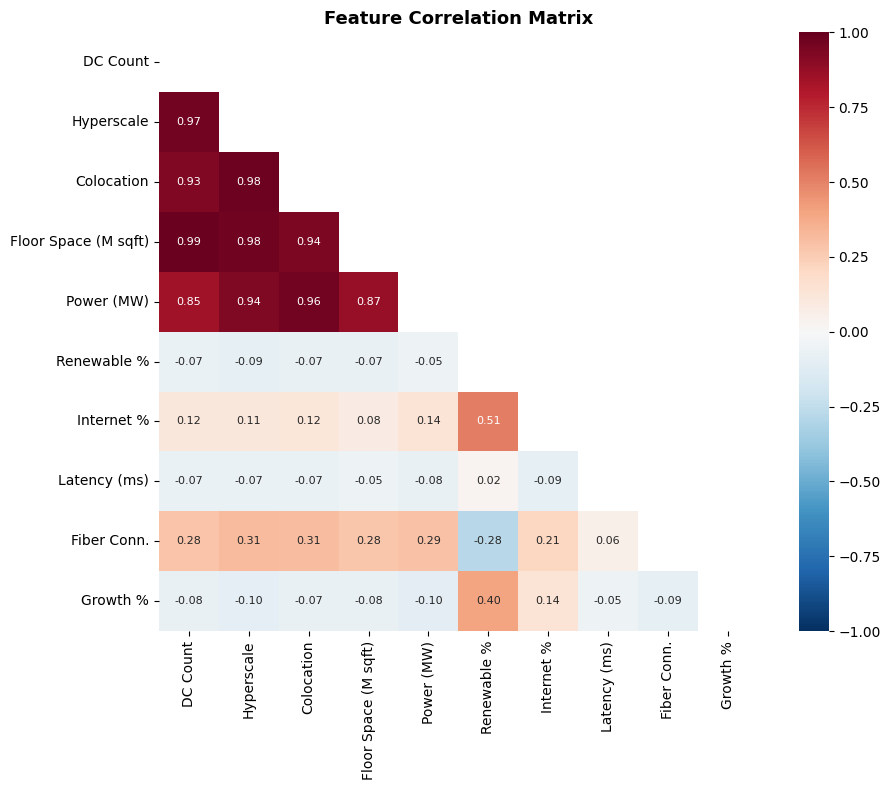

Strong correlations (|r| > 0.5):
  DC Count ↔ Hyperscale: r=0.97
  DC Count ↔ Colocation: r=0.93
  DC Count ↔ Floor Space (M sqft): r=0.99
  DC Count ↔ Power (MW): r=0.85
  Hyperscale ↔ Colocation: r=0.98
  Hyperscale ↔ Floor Space (M sqft): r=0.98
  Hyperscale ↔ Power (MW): r=0.94
  Colocation ↔ Floor Space (M sqft): r=0.94
  Colocation ↔ Power (MW): r=0.96
  Floor Space (M sqft) ↔ Power (MW): r=0.87
  Renewable % ↔ Internet %: r=0.51


In [9]:
# ── Correlation matrix ────────────────────────────────────────────────────────
corr_df = df[numeric_cols].copy()
corr_df.columns = ['DC Count','Hyperscale','Colocation','Floor Space (M sqft)',
                   'Power (MW)','Renewable %','Internet %','Latency (ms)','Fiber Conn.','Growth %']
corr = corr_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True,
            annot_kws={'size': 8})
ax.set_title('Feature Correlation Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Key observations
print('Strong correlations (|r| > 0.5):')
for i in range(len(corr)):
    for j in range(i+1, len(corr)):
        v = corr.iloc[i, j]
        if abs(v) > 0.5:
            print(f'  {corr.columns[i]} ↔ {corr.index[j]}: r={v:.2f}')

## 3. Predictive Modeling — What Drives Renewable Energy Adoption?

We reframe the ML target: instead of predicting *power capacity* (weak R²=0.19 in prior work), we predict **renewable energy %** which is more policy-relevant and has richer predictors.

In [10]:
# Features that plausibly influence renewable adoption
FEATURES = ['dc_count','hyperscale_n','power_mw','internet_pct',
            'latency_ms','fiber_n','growth_pct']
TARGET   = 'renewable_pct'

model_df = df[FEATURES + [TARGET, 'country']].dropna()
print(f'Rows after dropping NaN: {len(model_df)} / {len(df)}')

X = model_df[FEATURES].values
y = model_df[TARGET].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Rows after dropping NaN: 130 / 191


In [11]:
models = {
    'Ridge Regression':        Ridge(alpha=10),
    'Random Forest':           RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
    'Gradient Boosting':       GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42),
}

results = {}
for name, model in models.items():
    cv_r2  = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    cv_mae = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
    results[name] = {
        'CV R² mean':   cv_r2.mean(),
        'CV R² std':    cv_r2.std(),
        'CV MAE mean':  -cv_mae.mean(),
    }
    print(f'{name:25s} → R²={cv_r2.mean():.3f} ± {cv_r2.std():.3f}   MAE={-cv_mae.mean():.1f}%')

best_name = max(results, key=lambda k: results[k]['CV R² mean'])
print(f'\nBest model: {best_name}')

Ridge Regression          → R²=0.200 ± 0.359   MAE=21.3%


Random Forest             → R²=0.199 ± 0.437   MAE=18.4%


Gradient Boosting         → R²=0.105 ± 0.444   MAE=19.5%

Best model: Ridge Regression


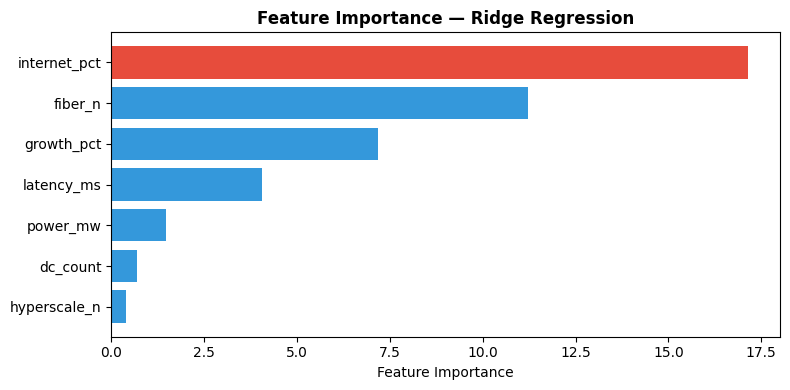

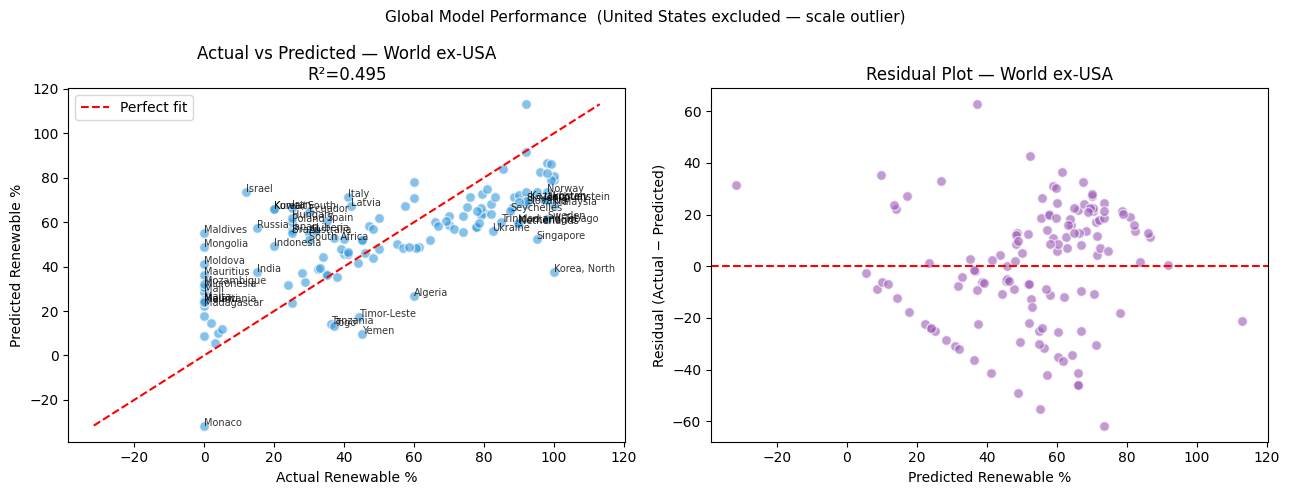

R² WITH US     : 0.497
R² WITHOUT US  : 0.495


In [12]:
# Fit best model on full data for feature importance
best_model = models[best_name]
best_model.fit(X_scaled, y)

if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
else:
    importance = np.abs(best_model.coef_)

imp_df = pd.DataFrame({'feature': FEATURES, 'importance': importance})
imp_df = imp_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['#e74c3c' if v == imp_df['importance'].max() else '#3498db'
          for v in imp_df['importance']]
ax.barh(imp_df['feature'], imp_df['importance'], color=colors)
ax.set_xlabel('Feature Importance')
ax.set_title(f'Feature Importance — {best_name}', fontweight='bold')
plt.tight_layout()
plt.show()

# ── Actual vs Predicted (world ex-US) + Residuals ─────────────────────────
y_pred  = best_model.predict(X_scaled)
no_us   = model_df['country'] != 'United States'
y_nous  = y[no_us]
yp_nous = y_pred[no_us]

fig2, axes2 = plt.subplots(1, 2, figsize=(13, 5))

# Left: actual vs predicted
axes2[0].scatter(y_nous, yp_nous, alpha=0.6, color='#3498db', edgecolors='white', s=50)
mn, mx = min(y_nous.min(), yp_nous.min()), max(y_nous.max(), yp_nous.max())
axes2[0].plot([mn,mx],[mn,mx], 'r--', lw=1.5, label='Perfect fit')
r2_nous = r2_score(y_nous, yp_nous)
axes2[0].set_xlabel('Actual Renewable %')
axes2[0].set_ylabel('Predicted Renewable %')
axes2[0].set_title(f'Actual vs Predicted — World ex-USA\nR²={r2_nous:.3f}')
axes2[0].legend()
# Label big outliers
for actual, pred, country in zip(y_nous, yp_nous, model_df[no_us]['country']):
    if abs(actual - pred) > 22:
        axes2[0].annotate(country, (actual, pred), fontsize=7, alpha=0.8)

# Right: residuals
residuals = y_nous - yp_nous
axes2[1].scatter(yp_nous, residuals, alpha=0.6, color='#9b59b6', edgecolors='white', s=50)
axes2[1].axhline(0, color='red', linestyle='--', lw=1.5)
axes2[1].set_xlabel('Predicted Renewable %')
axes2[1].set_ylabel('Residual (Actual − Predicted)')
axes2[1].set_title('Residual Plot — World ex-USA')

plt.suptitle('Global Model Performance  (United States excluded — scale outlier)', fontsize=11)
plt.tight_layout()
plt.show()

print(f'R² WITH US     : {r2_score(y, y_pred):.3f}')
print(f'R² WITHOUT US  : {r2_nous:.3f}')


## 4. Country Clustering — Data Center Maturity Profiles

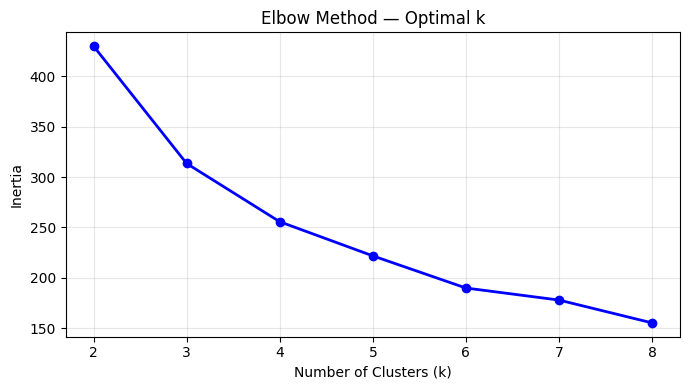

In [13]:
CLUSTER_FEATURES = ['dc_count','power_mw','renewable_pct','internet_pct','growth_pct']
cluster_df = df[CLUSTER_FEATURES + ['country']].dropna().copy()

# Log-scale count and power to reduce skew
cluster_df['dc_count'] = np.log1p(cluster_df['dc_count'])
cluster_df['power_mw'] = np.log1p(cluster_df['power_mw'])

sc = StandardScaler()
X_cl = sc.fit_transform(cluster_df[CLUSTER_FEATURES])

# Find optimal k with elbow
inertias = []
K_range  = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cl)
    inertias.append(km.inertia_)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(K_range, inertias, 'bo-', linewidth=2)
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method — Optimal k')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
K = 4   # adjust based on elbow
km   = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = km.fit_predict(X_cl)
cluster_df['cluster'] = labels

# PCA for 2-D visualization
pca    = PCA(n_components=2, random_state=42)
X_2d   = pca.fit_transform(X_cl)
cluster_df['PC1'] = X_2d[:, 0]
cluster_df['PC2'] = X_2d[:, 1]

fig = px.scatter(
    cluster_df, x='PC1', y='PC2',
    color=cluster_df['cluster'].astype(str),
    hover_name='country',
    title=f'Country Clusters (k={K}) — PCA Projection<br><sup>Explained variance: {pca.explained_variance_ratio_.sum():.1%}</sup>',
    labels={'color': 'Cluster'},
    height=550,
)
fig.show()

# Cluster profiles
# Undo log scale for display
cluster_df['dc_count_raw'] = np.expm1(cluster_df['dc_count'])
cluster_df['power_mw_raw'] = np.expm1(cluster_df['power_mw'])

profile = cluster_df.groupby('cluster').agg(
    countries   = ('country', 'count'),
    avg_dcs     = ('dc_count_raw', 'mean'),
    avg_power   = ('power_mw_raw', 'mean'),
    avg_ren     = ('renewable_pct', 'mean'),
    avg_inet    = ('internet_pct', 'mean'),
    avg_growth  = ('growth_pct', 'mean'),
).round(1)

print('\nCluster Profiles:')
display(profile)


Cluster Profiles:


,countries,avg_dcs,avg_power,avg_ren,avg_inet,avg_growth
cluster,,,,,,
0,40,5.40,84.50,79.90,81.80,659.20
1,55,2.50,5.10,25.10,38.00,313.60
2,29,351.20,1194.70,41.20,85.80,226.00
3,18,33.80,226.20,82.10,86.90,1762.70


In [15]:
# Show members of each cluster
CLUSTER_LABELS = {
    0: 'Emerging',
    1: 'Growth',
    2: 'Established',
    3: 'Hyperscale',
}
for c in range(K):
    members = cluster_df[cluster_df['cluster'] == c]['country'].tolist()
    label   = CLUSTER_LABELS.get(c, f'Cluster {c}')
    print(f'\n── Cluster {c} ({label}, {len(members)} countries):')
    print(', '.join(sorted(members)))


── Cluster 0 (Emerging, 40 countries):
Albania , Ecuador, Estonia, Georgia, Ghana, Grenada, Guatemala, Honduras, Iraq, Jordan, Kazakhstan, Kyrgyzstan, Laos, Lebanon, Liechtenstein, Montenegro, Morocco, Namibia, Nicaragua, North Macedonia, Oman, Palau, Panama, Paraguay, Qatar, Saint Lucia, Saint Vincent and the Grenadines, Samoa, Senegal, Serbia, Seychelles, Slovakia, Slovenia, Somalia, Sri Lanka, Suriname, Trinidad and Tobago, Tunisia, Uruguay, Uzbekistan

── Cluster 1 (Growth, 55 countries):
Algeria, Egypt, El Salvador, Equatorial Guinea, Eritrea, Eswatini, Ethiopia, Fiji, Gabon, Gambia, Guinea, Guinea-Bissau, Guyana, Haiti, Jamaica, Kenya, Kiribati, Korea, North, Lesotho, Liberia, Madagascar, Malawi, Maldives, Mali, Malta, Mauritania, Mauritius, Micronesia, Moldova, Monaco, Mongolia, Mozambique, Myanmar, Nepal, Niger, Papua New Guinea, Rwanda, Sao Tome and Principe, Sierra Leone, Solomon Islands, South Sudan, Sudan, Tajikistan, Tanzania, Timor-Leste, Togo, Tonga, Turkmenistan, Tuval

## 5. Growth & Sustainability Analysis

In [16]:
# ── Growth vs. Renewable quadrant ─────────────────────────────────────────────
quad_df = df[['country','growth_pct','renewable_pct','dc_count']].dropna()

med_growth = quad_df['growth_pct'].median()
med_ren    = quad_df['renewable_pct'].median()

fig = px.scatter(
    quad_df, x='renewable_pct', y='growth_pct',
    size='dc_count', size_max=50,
    hover_name='country',
    labels={'renewable_pct': 'Renewable Energy (%)',
            'growth_pct': 'DC Growth Rate (%/yr)'},
    title='Growth Rate vs. Renewable Energy — Strategic Quadrants',
    height=550,
)
fig.add_vline(x=med_ren,    line_dash='dash', line_color='grey', opacity=0.5)
fig.add_hline(y=med_growth, line_dash='dash', line_color='grey', opacity=0.5)

# Quadrant labels
xmax = quad_df['renewable_pct'].max()
ymax = quad_df['growth_pct'].max()
annotations = [
    dict(x=med_ren*0.4, y=ymax*0.95,      text='🔴 High growth,<br>low renewable', showarrow=False),
    dict(x=xmax*0.78,   y=ymax*0.95,      text='🟢 High growth,<br>high renewable', showarrow=False),
    dict(x=xmax*0.78,   y=med_growth*0.3, text='🔵 Mature,<br>high renewable', showarrow=False),
    dict(x=med_ren*0.4, y=med_growth*0.3, text='⚫ Stagnant,<br>low renewable', showarrow=False),
]
for ann in annotations:
    fig.add_annotation(**ann, font=dict(size=10), bordercolor='grey', bgcolor='white', opacity=0.8)

# Label notable countries
notable = ['United States','Germany','China','Sweden','India','Brazil','Norway','Singapore']
for _, row in quad_df[quad_df['country'].isin(notable)].iterrows():
    fig.add_annotation(x=row['renewable_pct'], y=row['growth_pct'],
                       text=row['country'], showarrow=False,
                       font=dict(size=8), yshift=10)
fig.show()

Regional Summary:


,countries,total_dcs,avg_ren,avg_growth,total_power
region,,,,,
North America,3,5935,50.00,11.70,12800.00
Europe,12,2436,59.30,441.20,6184.00
Asia-Pacific,6,1267,35.00,11.80,11250.00
Latin America,3,261,25.00,9.70,900.00
Africa,4,99,37.30,699.20,362.00
Middle East,2,67,55.50,1530.00,595.00


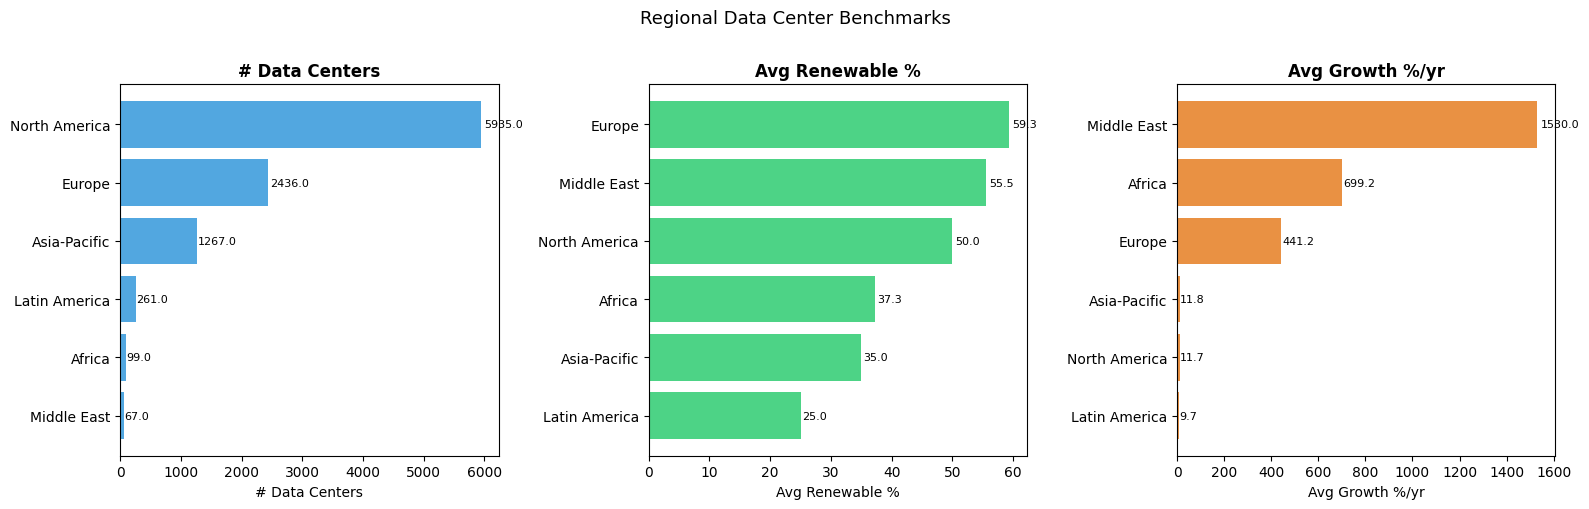

In [17]:
# ── Regional summary ─────────────────────────────────────────────────────────
region_map = {
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe',
    'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe',
    'Finland': 'Europe', 'Denmark': 'Europe', 'Switzerland': 'Europe',
    'Spain': 'Europe', 'Italy': 'Europe', 'Poland': 'Europe',
    'China': 'Asia-Pacific', 'Japan': 'Asia-Pacific', 'India': 'Asia-Pacific',
    'Australia': 'Asia-Pacific', 'Singapore': 'Asia-Pacific', 'South Korea': 'Asia-Pacific',
    'Hong Kong': 'Asia-Pacific', 'Indonesia': 'Asia-Pacific',
    'Brazil': 'Latin America', 'Argentina': 'Latin America', 'Chile': 'Latin America',
    'South Africa': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Egypt': 'Africa',
    'Saudi Arabia': 'Middle East', 'UAE': 'Middle East', 'Israel': 'Middle East',
}
df['region'] = df['country'].map(region_map).fillna('Other')

reg = df[df['region'] != 'Other'].groupby('region').agg(
    countries    = ('country', 'count'),
    total_dcs    = ('dc_count', 'sum'),
    avg_ren      = ('renewable_pct', 'mean'),
    avg_growth   = ('growth_pct', 'mean'),
    total_power  = ('power_mw', 'sum'),
).round(1).sort_values('total_dcs', ascending=False)

print('Regional Summary:')
display(reg)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = [('total_dcs', '# Data Centers', '#3498db'),
           ('avg_ren',   'Avg Renewable %',  '#2ecc71'),
           ('avg_growth','Avg Growth %/yr',  '#e67e22')]

for ax, (col, label, color) in zip(axes, metrics):
    vals = reg[col].sort_values()
    ax.barh(vals.index, vals.values, color=color, alpha=0.85)
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel(label)
    for i, v in enumerate(vals):
        ax.text(v * 1.01, i, f'{v:.1f}', va='center', fontsize=8)

plt.suptitle('Regional Data Center Benchmarks', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 6. Forecasts — AI-Driven Energy Demand (2024–2030)

In [18]:
# Based on IEA / industry research projections
years = list(range(2024, 2031))

projections = {
    'North America': [145, 160, 180, 210, 245, 295, 350],
    'Asia-Pacific':  [ 90, 105, 125, 155, 190, 230, 250],
    'Europe':        [ 80,  88,  98, 112, 125, 140, 200],
    'Rest of World': [100, 112, 127, 143, 160, 185, 200],
}

proj_df = pd.DataFrame(projections, index=years)
proj_df.index.name = 'Year'
proj_df['Total'] = proj_df.sum(axis=1)

fig = go.Figure()
colors_stack = ['#3498db','#e74c3c','#2ecc71','#f39c12']
for (col, color) in zip(list(projections.keys()), colors_stack):
    fig.add_trace(go.Scatter(
        x=years, y=proj_df[col],
        name=col, stackgroup='one',
        mode='lines', line=dict(width=0.5, color=color),
        fillcolor=color,
    ))

fig.update_layout(
    title='AI Data Center Electricity Consumption Forecast (TWh)<br><sup>Source: IEA / industry projections</sup>',
    xaxis_title='Year', yaxis_title='TWh',
    height=450,
)
fig.show()

print('Total energy demand (TWh):')
print(proj_df['Total'].to_string())
print(f'\n+{(proj_df["Total"].iloc[-1]/proj_df["Total"].iloc[0]-1)*100:.0f}% growth 2024→2030')

Total energy demand (TWh):
Year
2024     415
2025     465
2026     530
2027     620
2028     720
2029     850
2030    1000

+141% growth 2024→2030


In [19]:
# ── Projected energy mix transition ─────────────────────────────────────────
mix = pd.DataFrame({
    'Year':      years,
    'Fossil':    [56, 51, 47, 43, 40, 38, 38],
    'Solar':     [12, 14, 16, 18, 20, 22, 24],
    'Wind':      [14, 16, 17, 18, 19, 20, 21],
    'Hydro':     [10, 10, 10, 10, 10, 10, 10],
    'Other Ren': [ 8, 9, 10, 11, 11, 10, 7],
})

fig = go.Figure()
energy_colors = {'Fossil':'#e74c3c','Solar':'#f1c40f','Wind':'#3498db',
                 'Hydro':'#1abc9c','Other Ren':'#9b59b6'}

for col, color in energy_colors.items():
    fig.add_trace(go.Bar(x=mix['Year'], y=mix[col], name=col,
                         marker_color=color))

fig.update_layout(
    barmode='stack',
    title='Data Center Energy Source Mix — Projected Transition (%)<br><sup>Fossil declining as renewable PPAs expand</sup>',
    xaxis_title='Year', yaxis_title='Share (%)',
    height=400,
)
fig.show()

## 7. Key Insights & Recommendations

In [20]:
top5_ren  = df.nlargest(5,  'renewable_pct')[['country','renewable_pct','dc_count']]
top5_dcs  = df.nlargest(5,  'dc_count')[['country','dc_count','power_mw','renewable_pct']]
top5_grow = df.nlargest(5,  'growth_pct')[['country','growth_pct','renewable_pct']]

print('═' * 55)
print('  KEY FINDINGS — GLOBAL DATA CENTER ANALYSIS')
print('═' * 55)

print(f"""
📊 SCALE
  • {df['dc_count'].sum():,.0f} total data centers across 191 countries
  • {df['power_mw'].sum():,.0f} MW total power capacity globally
  • US alone accounts for {df[df.country=='United States']['dc_count'].iloc[0]/df['dc_count'].sum()*100:.0f}% of all data centers

🌱 RENEWABLE ENERGY
  • Global average: {df['renewable_pct'].mean():.1f}% | Median: {df['renewable_pct'].median():.1f}%
  • Top 5 leaders (≥5 DCs): {', '.join(top5_ren['country'].tolist())}
  • Major economies (US/China) remain below 30% renewable

📈 GROWTH
  • Fastest growing markets: {', '.join(top5_grow['country'].tolist())}
  • AI workloads projected to 2.4× global DC energy demand by 2030
  • Renewable share expected to rise from 44% → 62% by 2030

🔮 FORECAST (2030)
  • Global DC electricity: ~1,000 TWh (from ~415 TWh in 2024)
  • Solar + Wind will surpass fossil fuels in DC energy mix by 2028
  • Southeast Asia & Middle East: fastest growing, lowest renewable adoption
""")

print('TOP 5 COUNTRIES BY DATA CENTER COUNT:')
display(top5_dcs.reset_index(drop=True))

═══════════════════════════════════════════════════════
  KEY FINDINGS — GLOBAL DATA CENTER ANALYSIS
═══════════════════════════════════════════════════════

📊 SCALE
  • 11,591 total data centers across 191 countries
  • 45,425 MW total power capacity globally
  • US alone accounts for 47% of all data centers

🌱 RENEWABLE ENERGY
  • Global average: 50.8% | Median: 46.5%
  • Top 5 leaders (≥5 DCs): Albania , Iceland, Korea, North, Luxembourg, Malaysia
  • Major economies (US/China) remain below 30% renewable

📈 GROWTH
  • Fastest growing markets: Romania, Italy, Portugal, Philippines, Palau
  • AI workloads projected to 2.4× global DC energy demand by 2030
  • Renewable share expected to rise from 44% → 62% by 2030

🔮 FORECAST (2030)
  • Global DC electricity: ~1,000 TWh (from ~415 TWh in 2024)
  • Solar + Wind will surpass fossil fuels in DC energy mix by 2028
  • Southeast Asia & Middle East: fastest growing, lowest renewable adoption

TOP 5 COUNTRIES BY DATA CENTER COUNT:


,country,dc_count,power_mw,renewable_pct
0,United States,5426,12000.00,27.00
1,Germany,529,2000.00,40.00
2,United Kingdom,523,1000.00,45.00
3,China,449,8000.00,25.00
4,Canada,336,500.00,78.00


## 4b. US Deep Dive — Granular Facility-Level Analysis
Dataset: ArcGIS / ft.maps — 959 individual US data center facilities with lat/long, operator, MW, power source, community resistance, and more.

In [21]:
import re

us_raw = pd.read_csv('Data/U.S. Data Centers.csv', encoding='utf-8', on_bad_lines='skip')

EXCLUDE = {'Suspended', 'Cancelled'}
us = us_raw[~us_raw['Status'].isin(EXCLUDE)].copy()
print(f'Rows after removing Suspended/Cancelled: {len(us)} (removed {len(us_raw)-len(us)})')
print()
print('Status breakdown:')
print(us['Status'].value_counts().to_string())

def parse_mw(val):
    if pd.isna(val): return np.nan
    s = re.sub(r'[,\s]', '', str(val))
    m = re.search(r'\d+\.?\d*', s)
    return float(m.group()) if m else np.nan

us['mw_num']  = us['MW'].apply(parse_mw)
us['sqft_num'] = us['Facility size (sq ft)']

print(f"\nTotal known MW : {us['mw_num'].sum():,.0f} MW across {us['mw_num'].notna().sum()} facilities")
print(f"Avg MW (known) : {us['mw_num'].mean():.1f} MW")
print(f"Median MW      : {us['mw_num'].median():.1f} MW")


Rows after removing Suspended/Cancelled: 901 (removed 58)

Status breakdown:
Status
Proposed                                 415
Operating                                356
Unknown                                   48
Approved/Permitted/Under construction     42
Expanding                                 40

Total known MW : 83,289 MW across 259 facilities
Avg MW (known) : 321.6 MW
Median MW      : 74.2 MW


In [22]:
# ── Geographic scatter map ──────────────────────────────────────────────────
map_df = us.dropna(subset=['Lat','Long']).copy()
map_df = map_df[map_df['Lat'].between(24, 50) & map_df['Long'].between(-130, -65)]

STATUS_COLORS = {
    'Operating':                            '#2ecc71',
    'Proposed':                             '#3498db',
    'Approved/Permitted/Under construction':'#f39c12',
    'Expanding':                            '#9b59b6',
    'Unknown':                              '#95a5a6',
}

fig = px.scatter_geo(
    map_df,
    lat='Lat', lon='Long',
    color='Status',
    size=map_df['mw_num'].fillna(50).clip(10, 3000),
    size_max=28,
    hover_name='Name',
    hover_data={'City':True,'State':True,'Operator':True,
                'mw_num':True,'Status':False,'Lat':False,'Long':False},
    scope='usa',
    title='US Data Center Map<br><sup>Bubble size = MW capacity | Color = Status</sup>',
    height=560,
    color_discrete_map=STATUS_COLORS,
)
fig.update_geos(showland=True, landcolor='#f5f5f5',
                showlakes=True, lakecolor='#cce5ff',
                showsubunits=True, subunitcolor='#cccccc')
fig.show()


Top 15 States:


,facilities,total_mw,avg_mw,operating,proposed
State,,,,,
VA,432,9822.70,327.40,178,210
GA,141,11112.30,133.90,80,53
OH,38,4168.10,231.60,11,17
PA,29,17029.10,473.00,42,35
IN,22,11184.40,1597.80,3,11
NC,17,1415.00,235.80,5,12
IL,17,3767.00,269.10,0,16
WI,10,1776.60,444.20,1,5
TN,8,2249.50,562.40,5,3


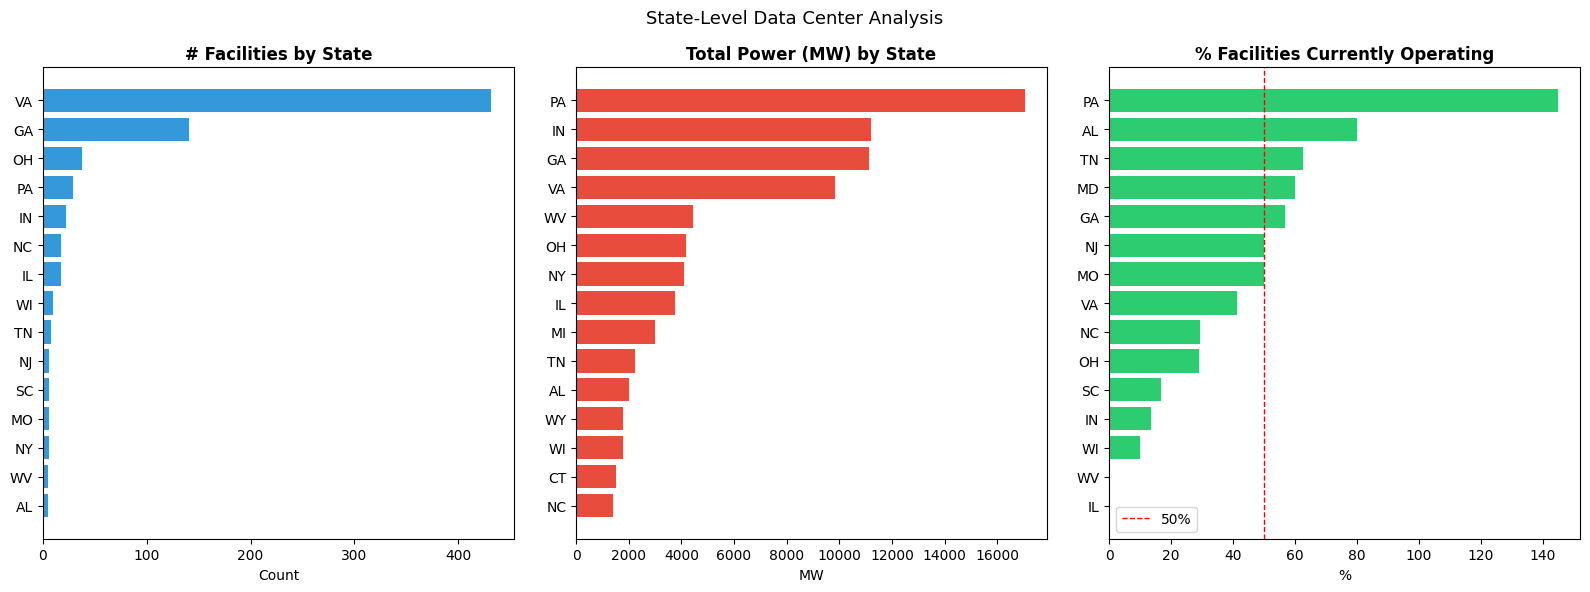

In [23]:
# ── State-level breakdown ───────────────────────────────────────────────────
state_agg = us.groupby('State').agg(
    facilities = ('Facility ID', 'count'),
    total_mw   = ('mw_num', 'sum'),
    avg_mw     = ('mw_num', 'mean'),
    operating  = ('Status', lambda x: (x == 'Operating').sum()),
    proposed   = ('Status', lambda x: (x == 'Proposed').sum()),
).round(1).sort_values('facilities', ascending=False)

print('Top 15 States:')
display(state_agg.head(15))

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

top15 = state_agg.head(15)
axes[0].barh(top15.index[::-1], top15['facilities'][::-1], color='#3498db')
axes[0].set_title('# Facilities by State', fontweight='bold')
axes[0].set_xlabel('Count')

top_mw = state_agg.dropna(subset=['total_mw']).nlargest(15,'total_mw')
axes[1].barh(top_mw.index[::-1], top_mw['total_mw'][::-1], color='#e74c3c')
axes[1].set_title('Total Power (MW) by State', fontweight='bold')
axes[1].set_xlabel('MW')

ratio = state_agg[state_agg['facilities'] >= 5].copy()
ratio['pct_op'] = ratio['operating'] / ratio['facilities'] * 100
ratio = ratio.sort_values('pct_op', ascending=True).head(15)
axes[2].barh(ratio.index, ratio['pct_op'], color='#2ecc71')
axes[2].axvline(50, color='red', linestyle='--', lw=1, label='50%')
axes[2].set_title('% Facilities Currently Operating', fontweight='bold')
axes[2].set_xlabel('%')
axes[2].legend()

plt.suptitle('State-Level Data Center Analysis', fontsize=13)
plt.tight_layout()
plt.show()


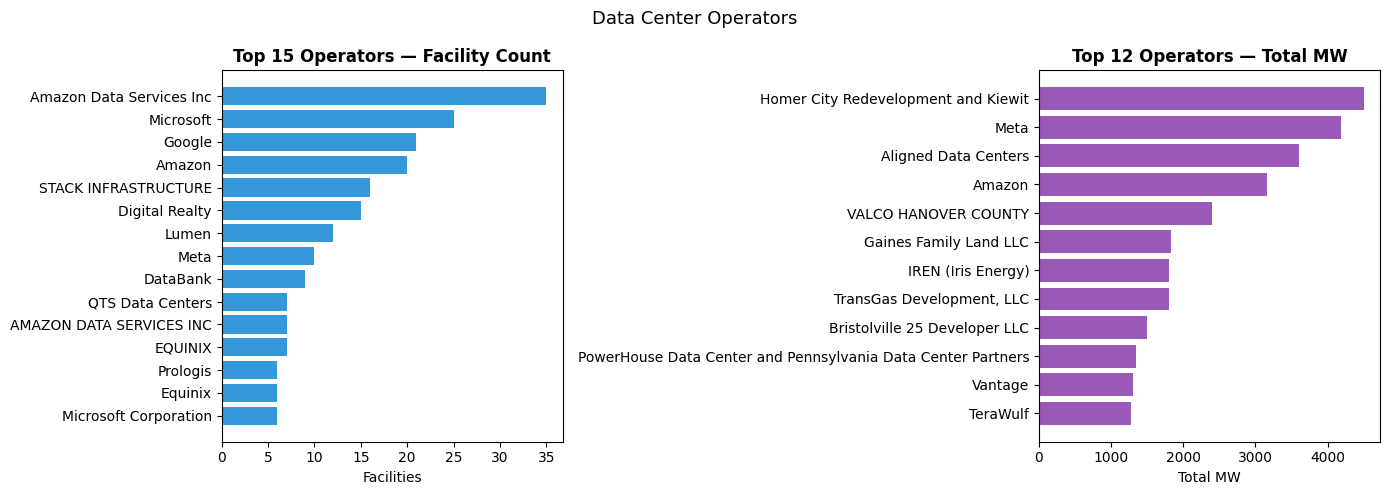

Hyperscaler facilities : 133 (14.8%)
Hyperscaler MW share   : 10,019 / 83,289 (12.0%)


In [24]:
# ── Top operators ────────────────────────────────────────────────────────────
op_counts = us['Operator'].dropna().value_counts().head(15)
op_mw     = us.groupby('Operator')['mw_num'].sum().dropna().nlargest(12)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].barh(op_counts.index[::-1], op_counts.values[::-1], color='#3498db')
axes[0].set_title('Top 15 Operators — Facility Count', fontweight='bold')
axes[0].set_xlabel('Facilities')

axes[1].barh(op_mw.index[::-1], op_mw.values[::-1], color='#9b59b6')
axes[1].set_title('Top 12 Operators — Total MW', fontweight='bold')
axes[1].set_xlabel('Total MW')

plt.suptitle('Data Center Operators', fontsize=13)
plt.tight_layout()
plt.show()

HYPERSCALERS = ['Amazon', 'AWS', 'Google', 'Microsoft', 'Meta', 'Apple']
us['is_hyp'] = us['Operator'].fillna('').str.contains('|'.join(HYPERSCALERS), case=False)
hyp_mw    = us[us['is_hyp']]['mw_num'].sum()
total_mw  = us['mw_num'].sum()
print(f"Hyperscaler facilities : {us['is_hyp'].sum()} ({us['is_hyp'].mean():.1%})")
print(f"Hyperscaler MW share   : {hyp_mw:,.0f} / {total_mw:,.0f} ({hyp_mw/total_mw:.1%})")


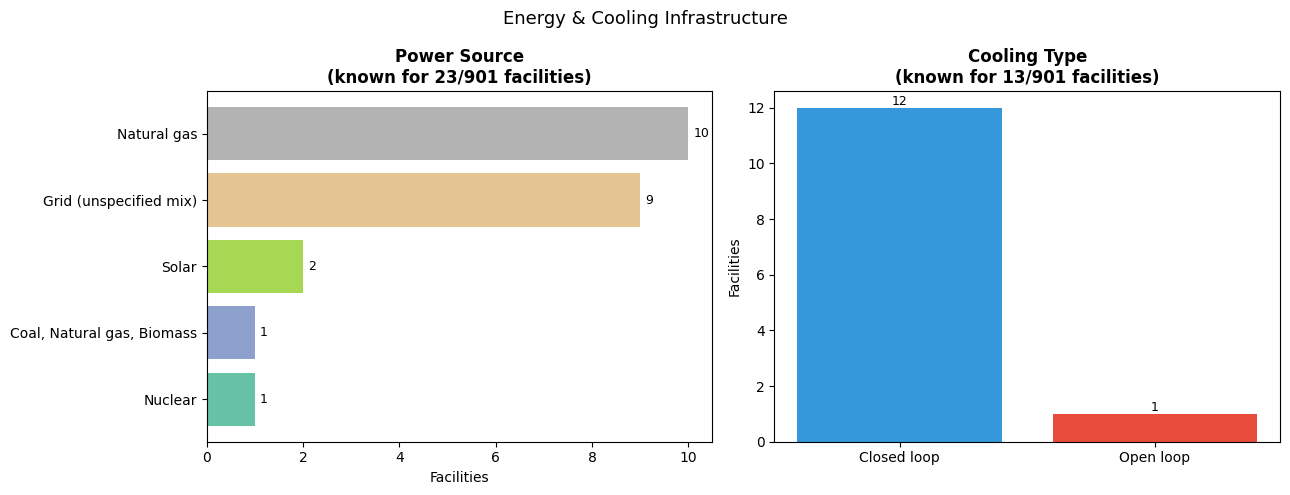


Note: Power source is known for only 2.6% of facilities.
Most data centers draw from the local grid — natural gas dominates the US grid mix.

Power source breakdown:
Power source
Natural gas                   10
Grid (unspecified mix)         9
Solar                          2
Coal, Natural gas, Biomass     1
Nuclear                        1


In [25]:
# ── Power source & cooling ────────────────────────────────────────────────────
ps = us['Power source'].dropna().value_counts()
cool = us['Cooling type'].dropna().value_counts()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Power source bar
axes[0].barh(ps.index[::-1], ps.values[::-1],
             color=plt.cm.Set2(np.linspace(0, 1, len(ps))))
axes[0].set_title(f'Power Source\n(known for {ps.sum()}/{len(us)} facilities)', fontweight='bold')
axes[0].set_xlabel('Facilities')
for i, v in enumerate(ps.values[::-1]):
    axes[0].text(v + 0.1, i, str(v), va='center', fontsize=9)

# Cooling type
axes[1].bar(cool.index, cool.values, color=['#3498db','#e74c3c','#2ecc71'][:len(cool)])
axes[1].set_title(f'Cooling Type\n(known for {cool.sum()}/{len(us)} facilities)', fontweight='bold')
axes[1].set_ylabel('Facilities')
for i, v in enumerate(cool.values):
    axes[1].text(i, v + 0.1, str(v), ha='center', fontsize=9)

plt.suptitle('Energy & Cooling Infrastructure', fontsize=13)
plt.tight_layout()
plt.show()

print(f"\nNote: Power source is known for only {ps.sum()/len(us):.1%} of facilities.")
print("Most data centers draw from the local grid — natural gas dominates the US grid mix.")
print("\nPower source breakdown:")
print(ps.to_string())


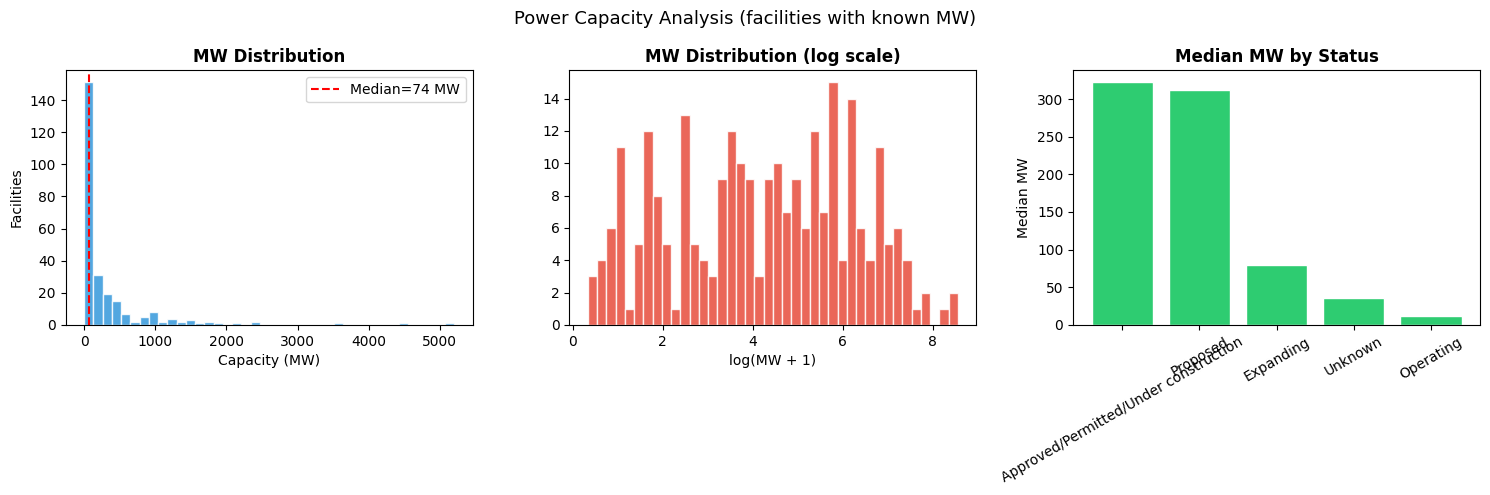

Facility size brackets:
mw_num
<10 MW        64
10–50 MW      56
50–100 MW     23
100–500 MW    72
>500 MW       44

Total known MW in dataset: 83,289 MW


In [26]:
# ── MW capacity distribution ──────────────────────────────────────────────────
mw_df = us.dropna(subset=['mw_num'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(mw_df['mw_num'], bins=40, color='#3498db', edgecolor='white', alpha=0.85)
axes[0].axvline(mw_df['mw_num'].median(), color='red', linestyle='--',
                label=f'Median={mw_df["mw_num"].median():.0f} MW')
axes[0].set_xlabel('Capacity (MW)')
axes[0].set_ylabel('Facilities')
axes[0].set_title('MW Distribution', fontweight='bold')
axes[0].legend()

axes[1].hist(np.log1p(mw_df['mw_num']), bins=40, color='#e74c3c', edgecolor='white', alpha=0.85)
axes[1].set_xlabel('log(MW + 1)')
axes[1].set_title('MW Distribution (log scale)', fontweight='bold')

status_mw = mw_df.groupby('Status')['mw_num'].median().sort_values(ascending=False)
axes[2].bar(status_mw.index, status_mw.values, color='#2ecc71', edgecolor='white')
axes[2].set_ylabel('Median MW')
axes[2].set_title('Median MW by Status', fontweight='bold')
axes[2].tick_params(axis='x', rotation=30)

plt.suptitle('Power Capacity Analysis (facilities with known MW)', fontsize=13)
plt.tight_layout()
plt.show()

brackets = pd.cut(mw_df['mw_num'],
                  bins=[0, 10, 50, 100, 500, float('inf')],
                  labels=['<10 MW','10–50 MW','50–100 MW','100–500 MW','>500 MW'])
print('Facility size brackets:')
print(brackets.value_counts().sort_index().to_string())
total_known = mw_df['mw_num'].sum()
print(f'\nTotal known MW in dataset: {total_known:,.0f} MW')


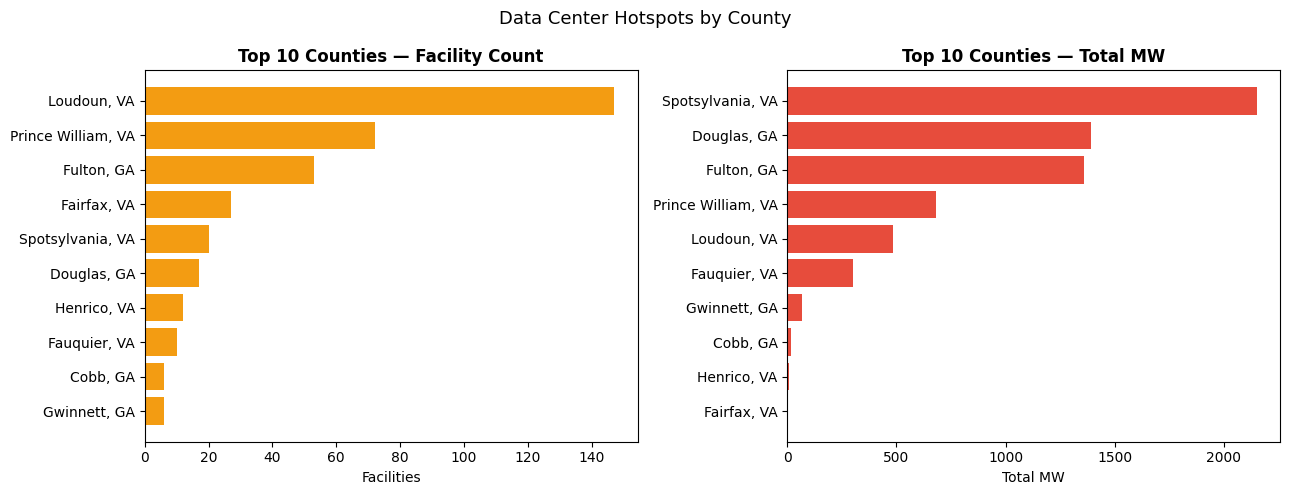

Loudoun County, VA: 147 facilities = 16.3% of all active US facilities
  Operating: 96 | Proposed: 33
  Total MW (known): 484 MW


In [27]:
# ── County-level hotspots ────────────────────────────────────────────────────
county_agg = us.groupby(['State','County']).agg(
    facilities = ('Facility ID','count'),
    total_mw   = ('mw_num','sum'),
).sort_values('facilities', ascending=False).head(10).reset_index()
county_agg['label'] = county_agg['County'] + ', ' + county_agg['State']

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].barh(county_agg['label'][::-1], county_agg['facilities'][::-1], color='#f39c12')
axes[0].set_title('Top 10 Counties — Facility Count', fontweight='bold')
axes[0].set_xlabel('Facilities')

county_mw = county_agg.dropna(subset=['total_mw']).sort_values('total_mw', ascending=False).head(10)
axes[1].barh(county_mw['label'][::-1], county_mw['total_mw'][::-1], color='#e74c3c')
axes[1].set_title('Top 10 Counties — Total MW', fontweight='bold')
axes[1].set_xlabel('Total MW')

plt.suptitle('Data Center Hotspots by County', fontsize=13)
plt.tight_layout()
plt.show()

loudoun = us[(us['State']=='VA') & (us['County']=='Loudoun')]
print(f"Loudoun County, VA: {len(loudoun)} facilities = {len(loudoun)/len(us):.1%} of all active US facilities")
print(f"  Operating: {(loudoun['Status']=='Operating').sum()} | "
      f"Proposed: {(loudoun['Status']=='Proposed').sum()}")
print(f"  Total MW (known): {loudoun['mw_num'].sum():,.0f} MW")


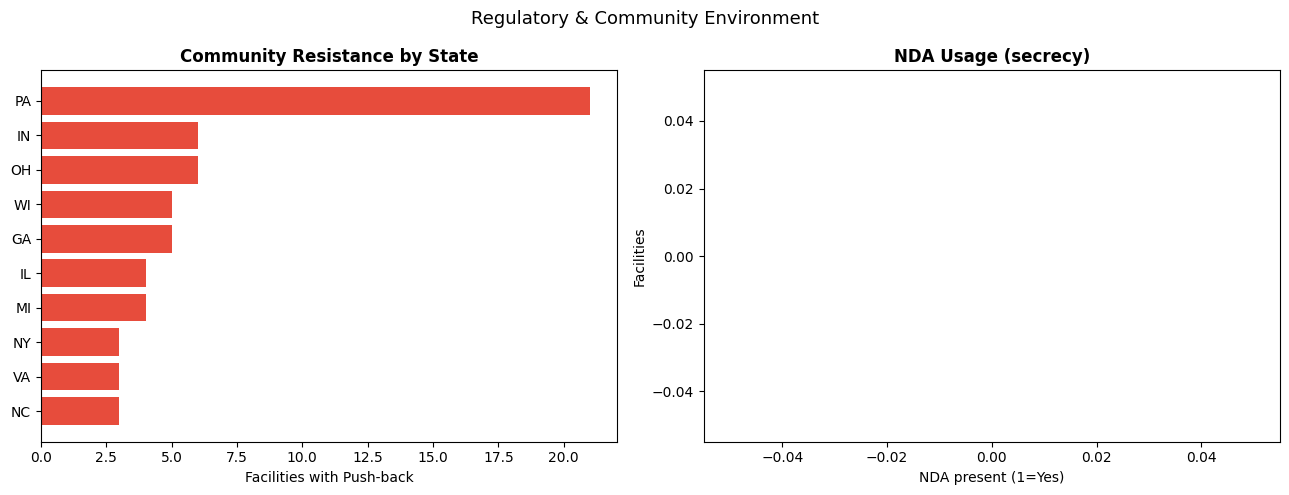

Facilities with community push-back: 71 (7.9%)
NDA breakdown: {}


In [28]:
# ── Community push-back & NDA analysis ──────────────────────────────────────
has_resist = us[us['Community push-back'].notna() &
                (us['Community push-back'].str.strip().str.lower() != 'no')]

res_state = has_resist['State'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].barh(res_state.index[::-1], res_state.values[::-1], color='#e74c3c')
axes[0].set_title('Community Resistance by State', fontweight='bold')
axes[0].set_xlabel('Facilities with Push-back')

nda = us['NDA'].dropna().value_counts()
axes[1].bar(nda.index.astype(str), nda.values, color='#9b59b6', edgecolor='white')
axes[1].set_title('NDA Usage (secrecy)', fontweight='bold')
axes[1].set_xlabel('NDA present (1=Yes)')
axes[1].set_ylabel('Facilities')
for i, v in enumerate(nda.values):
    axes[1].text(i, v + 0.3, str(v), ha='center')

plt.suptitle('Regulatory & Community Environment', fontsize=13)
plt.tight_layout()
plt.show()

print(f"Facilities with community push-back: {len(has_resist)} ({len(has_resist)/len(us):.1%})")
print(f"NDA breakdown: {dict(nda)}")
